In [1]:
from google.colab import files
uploaded = files.upload()

Saving AMZN.csv to AMZN.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import plotly.express as px
import plotly.graph_objects as go

In [3]:
amzn_stocks = pd.read_csv('AMZN.csv')
amzn_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
amzn_stocks.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
amzn_stocks.shape

(6257, 7)

In [6]:
amzn_stocks.notna().sum()

Date         6257
Open         6257
High         6257
Low          6257
Close        6257
Adj Close    6257
Volume       6257
dtype: int64

In [7]:
print(f'Timestamp of the earliest stock: {min(amzn_stocks["Date"])}\n\
Timestamp of the latest stock: {max(amzn_stocks["Date"])}')

Timestamp of the earliest stock: 1997-05-15
Timestamp of the latest stock: 2022-03-24


In [8]:
fig = px.line(amzn_stocks, x='Date', y=['Low', 'High'], template='plotly_dark')
fig.update_layout(
    title={'text': 'High vs Low Amazon Stock Prices over the 1997-2022 period',
           'y': 0.9,
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title='Dates, years',
    yaxis_title='Stock Price Value'
)
fig.show()

In [9]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x=amzn_stocks['Date'],
                             open=amzn_stocks['Open'],
                             high=amzn_stocks['High'],
                             low=amzn_stocks['Low'],
                             close=amzn_stocks['Close'],
                             increasing_line_color='magenta',
                             decreasing_line_color='cyan',
                             showlegend=False))

fig.update_layout(title={'text': 'OHLC Chart',
                         'y': 0.9,
                         'x': 0.5,
                         'xanchor': 'center'},
                  xaxis_title='Date',
                  yaxis_title='Price',
                  template='plotly_dark')

fig.show()

In [10]:
fig = px.bar(data_frame=amzn_stocks,
             x='Date',
             y='Volume',
             template='plotly_dark',
             opacity=1)

fig.update_layout(
    title={'text': 'Trading Volume Over Time',
           'y': 0.9,
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title='Dates, years',
    yaxis_title='Volume',
    bargap=0,
    bargroupgap=0
)

fig.show()

In [11]:
amzn_stocks['MA30'] = amzn_stocks['Close'].rolling(window=30).mean()
amzn_stocks['MA90'] = amzn_stocks['Close'].rolling(window=90).mean()

fig = px.line(amzn_stocks,
              x='Date',
              y=['Close', 'MA30', 'MA90'],
              template='plotly_dark')
fig.update_layout(
    title={'text': 'Stock Close Prices with Moving Averages',
           'y': 0.9,
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title='Dates, years',
    yaxis_title='Price',
    bargap=0,
    bargroupgap=0
)
fig.show()
amzn_stocks.drop(columns=['MA30', 'MA90'], inplace=True)

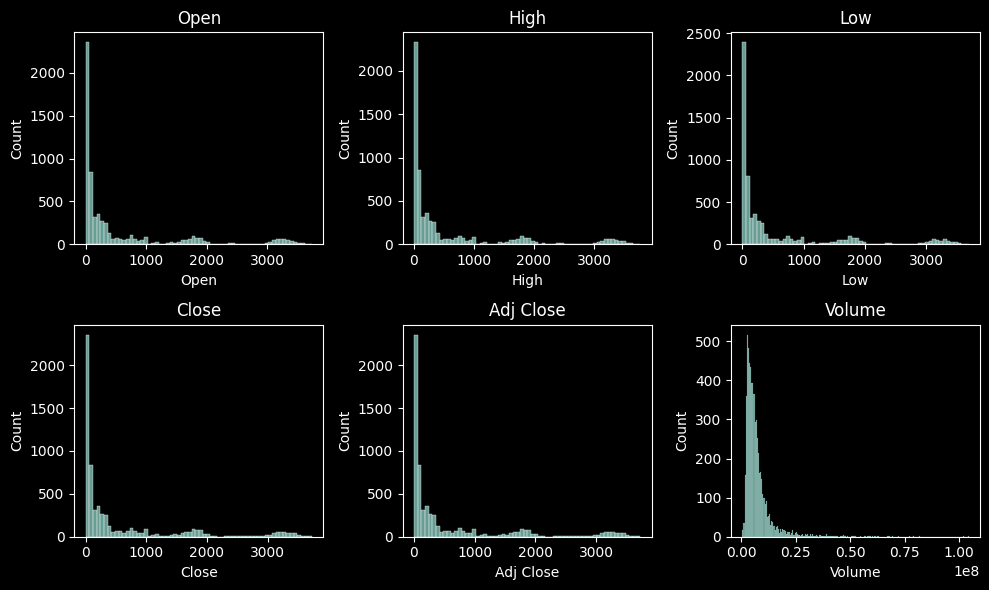

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(amzn_stocks.columns[1:]):
  sns.histplot(amzn_stocks[col], ax=axes[i])
  axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [22]:
def lag_data(df: pd.DataFrame, lag_param=5) -> tuple[pd.DataFrame, pd.Series]:
  """
  A function which splits the dataset into X and y to enable forecasting.

  Params:
    Args:
      df: dataframe we want to split.
    Kwargs:
      lag_param: the size of the window which defines how many past days'
data we are using for next day's stock.

  Returns: tuple of dataframe X (predictors) and series y (target variable).

  """
  df_as_numpy = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_numpy)-lag_param):
      X.append(df_as_numpy[i:i+lag_param].flatten())
      y.append(df_as_numpy[i+lag_param])

  X_df = pd.DataFrame(X, columns=[f'lag_{j}_{col}' for j in range(lag_param) for col in df.columns])
  y_series = pd.Series(y, index=X_df.index)

  return X_df, y_series

In [29]:
X, y = lag_data(amzn_stocks)
X.shape, y.shape

((6252, 35), (6252,))

In [30]:
def rolling_window_split(X: pd.DataFrame, y: pd.Series, train_window: int, val_window: int, step_size: int):
  """
  A function which implements Rolling Window splitting technique which is
particularly used for FTS algorithms.
The technique's visual representations:

Iteration 1:
| Train 1        | Validation 1 |
|----------------|--------------|

Iteration 2:
   | Train 2         | Validation 2 |
   |-----------------|--------------|

Iteration 3:
       |Train 3           | Validation 3 |
       |------------------|--------------|


  Args:
    X: predictors' data.
    y: a target variable.
    train_window: a fixed-length training subset for each iteration.
    val_window: a fixed-length validation subset for each iteration.
    step_size: a value by which we are moving forward after each iteration.

  Returns:
    tuple: a data structure containing splits for X and y train and validation subsets.
"""
  X_train_splits = []
  X_val_splits = []
  y_train_splits = []
  y_val_splits = []

  for start in range(0, len(X)-train_window-val_window, step_size):
      end_train = start+train_window
      end_val = end_train+val_window

      X_train = X.iloc[start:end_train]
      y_train = y.iloc[start:end_train]
      X_val = X.iloc[end_train:end_val]
      y_val = y.iloc[end_train:end_val]

      X_train_splits.append(X_train)
      X_val_splits.append(X_val)
      y_train_splits.append(y_train)
      y_val_splits.append(y_val)

  return X_train_splits, X_val_splits, y_train_splits, y_val_splits